# Sentiment Analysis

## Table of Contents
* [Build spaCy Pipeline](#spacy_pipeline)
* [Helper Functions](#helper_functions)
    * [Remove Negations](#negations)
    * [Convert to Sentiment Analysis Dataframes](#sa_dataframes)
    * [Polarity Helpers](#get_polarity)
    * [Plotting Helpers](#get_plots)
* [Character List](#character_list)
* [Get Data for All Characters](#data_characters)
* [Sentiment Analysis Using spacytextblob](#sa_spacytextblob)
* [Make Sentiment Analysis Dataframe per Character](#sa_df_character)
* [Polarity Distributions](#polarity_dist)
* [Wordclouds](#wordclouds)
* [Line Plots](#lineplots)
* [Barcode Plots](#barcodeplots)
* [Compare spacytextblob to Other Sentiment Analysis Tools](#tool_comparison)


In [1]:
from bs4 import BeautifulSoup
import requests
import os
from os import path
import re
import pandas as pd
import numpy as np
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter

## Build spaCy Pipeline <a class="anchor" id="spacy_pipeline"></a>


In [2]:
# load spacy
nlp = spacy.load("en_core_web_sm")
# add spacytextblob to pipeline
nlp.add_pipe("spacytextblob")
# check if added to pipe
nlp.components

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x193f2b371c0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x193f2b37820>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x193f288cd60>),
 ('senter', <spacy.pipeline.senter.SentenceRecognizer at 0x193f29a6e80>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x193f2b8e380>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x193f2b8ef40>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x193f2b5d0b0>),
 ('spacytextblob',
  <spacytextblob.spacytextblob.SpacyTextBlob at 0x193f2890040>)]

## Helper Functions <a class="anchor" id="helper_functions"></a>

### Remove Apostrophes from Negations (don't, haven't, ...) <a class="anchor" id="negations"></a>

In [3]:
def write_out_negotiations(text):
    
    # haven't, hasn't

    text = re.sub("haven't", "have not", text)
    text = re.sub("Haven't", "Have not", text)
    text = re.sub("hasn't", "has not", text)
    text = re.sub("Hasn't", "Has not", text)

    ## isn't, can't, don't

    text = re.sub("mustn't", "must not", text)
    text = re.sub("Mustn't", "Must not", text)

    text = re.sub("can'", "can not", text)
    text = re.sub("Can't", "Can not", text)

    text = re.sub("isn't", "is not", text)
    text = re.sub("Isn't", "Is not", text)

    text = re.sub("aren't", "are not", text)
    text = re.sub("Aren't", "Are not", text)

    text = re.sub("don't", "do not", text)
    text = re.sub("Don't", "Do not", text)

    text = re.sub("doesn't", "does not", text)
    text = re.sub("doesn't", "does not", text)

    text = re.sub("didn't", "did not", text)
    text = re.sub("Didn't", "Did not", text)

    ## wasn't, won't

    text = re.sub("wasn't", "was not", text)
    text = re.sub("Wasn't", "Was not", text)

    text = re.sub("won't", "will not", text)
    text = re.sub("Won't", "Will not", text)

    ## wouldn't, couldn't

    text = re.sub("couldn't", "could not", text)
    text = re.sub("shouldn't", "should not", text)
    
    text = re.sub("“", "", text)
    text = re.sub("”", "", text)
    
    # text = re.sub(r"\.", "", text)
    # text = re.sub(";", "", text)
    # text = re.sub(",", "", text)
    
    text = re.sub(r"\s\s", " ", text)
    text = text.strip()
    
    return text

### Convert Text to Dataframes for Sentiment Analysis <a class="anchor" id="sa_dataframes"></a>

In [4]:
def make_sa_df(text, character_name):
    doc = nlp(text)
    doc_sa = doc._.assessments
    doc_sa_df = pd.DataFrame(doc_sa, columns=["Word", "Polarity", "Subjectivity", "Unused Value"])
    doc_sa_df.insert(0, 'Number', range(1, 1 + len(doc_sa_df)))
    doc_sa_df.insert(1, 'Character', character_name)
    doc_sa_df = doc_sa_df[["Number", "Character", "Word", "Polarity", "Subjectivity"]]
    return doc_sa_df

### Helpers to Get Polarity <a class="anchor" id="get_polarity"></a>

#### Sentence Level

In [5]:
def getPolarityPerSentence(doc):
    counter = 0
    for span in doc.sents:
        print(span.text, span._.polarity)
        counter += 1
    print(f'Total: {counter} sentences')   

In [6]:
def getPolarityPerSentenceWithoutZero(doc):
    counter = 0
    for span in doc.sents:
        if(span._.polarity != 0.0):
            print(span.text, span._.polarity)
            counter += 1
    print(f'Total: {counter} sentences')    

In [7]:
def getSentencesWithZeroPolarity(doc):
    counter = 0
    for span in doc.sents:
        if(span._.polarity == 0.0):
            print(span.text, span._.polarity)
            counter += 1
    print(f'Total: {counter} sentences')   

In [8]:
def getPolarityPerSentenceBayes(text):
    sent = re.split(r"[\.!?]", text)
    counter = 0
    for sentence in sent:
        blob = TextBlob(sentence, analyzer=NaiveBayesAnalyzer())
        print(sentence, blob.sentiment)
        counter += 1
    print(f'Total: {counter} sentences')

#### Word Level

In [9]:
def getPolarityPerWord(doc):
    counter = 0
    for token in doc:
        print(token.text, token.pos_, token._.polarity)
        counter += 1
    print(f'Total: {counter} words')

In [10]:
def getPolarityPerWordWithoutZeros(doc):
    counter = 0
    for token in doc:
        if(token._.polarity != 0.0):
            print(token.text, token.pos_, token._.polarity)
            counter += 1
    print(f'Total: {counter} words')

In [11]:
def getZeroPolarityPerWord(doc):
    counter = 0
    for token in doc:
        if(token._.polarity == 0.0):
            print(token.text, token.pos_, token._.polarity)
            counter += 1
    print(f'Total: {counter} words')

In [12]:
def getPolarityPerWordBayes(word_list):
    counter = 0
    for word in word_list:
        blob = TextBlob(word, analyzer=NaiveBayesAnalyzer())
        print(word, blob.sentiment)
        counter += 1
    print(f'Total: {counter} words')   

### Helpers for Plotting <a class="anchor" id="get_plots"></a>

#### Barcode Plot→ [Barcodeplots](#barcodeplots) <a class="anchor" id="barcodeplot_function"></a>


In [13]:
def barcodeplot(data_start, data_end, character):
    # mean - polarity first 300 words
    mean_start = round(np.mean(data_start), 2)
    
    # plot first 300 words
    plt.figure(figsize=(20, 2), dpi=80)
    plt.gca().get_yaxis().set_ticks([])
    plt.gca().get_xaxis().set_ticks([])
    gradient = np.vstack((data_start, data_start))
    plt.title(f"{character} SA of first 300 words (Average: {mean_start})", fontsize=14)
    plt.imshow(gradient, aspect='auto', cmap=plt.get_cmap('RdYlGn'))
    #plt.show()
    
    # save start plot
    path_1 = f'visualizations/barcodeplots/barcode_start_{character}.jpg'
    plt.savefig(path_1, dpi=300)
    
    # mean - polarity last 300 words
    mean_end = round(np.mean(data_end), 2)
    
    # difference between means
    mean_diff = round((mean_end - mean_start),2)
    print(f'Differenz Start-Ende: {mean_diff}')
    
    # last 300 words
    plt.figure(figsize=(20, 2), dpi=80)
    plt.gca().get_yaxis().set_ticks([])
    plt.gca().get_xaxis().set_ticks([])
    gradient = np.vstack((data_end, data_end))
    plt.title(f"{character} SA of last 300 words (Average: {mean_end})", fontsize=14)
    plt.imshow(gradient, aspect='auto', cmap=plt.get_cmap('RdYlGn'))
    #plt.show()
    
    # save end plot
    path_2 = f'visualizations/barcodeplots/barcode_end_{character}.jpg'
    plt.savefig(path_2, dpi=300)

#### Line Plot → [Lineplots](#lineplots) <a class="anchor" id="lineplot_function"></a>

In [14]:
def make_line_plot(data, character_name):
    plt.figure(figsize=(15,2))
    sns.set_style("darkgrid")
    lineplot = sns.lineplot(x="Number", y="Polarity", color="darkblue", linewidth=1,
                 data=data)
    lineplot.set_title(f"Sentiment Analysis {character_name}", fontsize=15, fontweight="bold")
    # lineplot.set_xlabel("Verlauf", fontsize=15, fontweight="bold")
    lineplot.set_ylabel("Polarity Index", fontsize=12, fontweight="bold")
    lineplot.axhline(0, color="black", ls="--")
    return lineplot

#### Wordclouds

In [70]:
# function to generate wordcloud
def make_wordcloud(data):
    stopwords = list(STOPWORDS)
    stopwords.append("will")
    wordcloud = WordCloud(background_color = 'white', stopwords=stopwords, collocations=False, width=1920, height=1080).generate(data)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    return wordcloud

In [93]:
# extract wordstring from the sentiment analysis table
def getPolarityWordsForCloud(data):  
    sa_words = ""
    for word in data["Word"]:
        sa_words += f'{word} '
    sa_words = re.sub(r"'!',?", "", sa_words)
    sa_words = re.sub(r"[\[\]',]", "", sa_words)
    sa_words = re.sub(r"\s+", " ", sa_words)
    return sa_words

## Character List <a class="anchor" id="character_list"></a>

In [15]:
# get list with all characters
characters_list = ["frodo", "gandalf", "sam", "merry", "pippin", "aragorn", "arwen", "eowyn", "legolas", "gimli", "theoden", "saruman", "gollum", "smeagol", "sauron"]

## Data for all characters <a class="anchor" id="data_characters"></a>

Example for variable names:
* *gandalf* - complete dialog text of Gandalf
* *gandalf_300_start* - dialog text (first 300 words) of Gandalf
* *gandalf_300_end* - dialog text (last 300 words) of Gandalf

In [16]:
with open("data/gandalf.txt") as f:
    gandalf = f.read()
    gandalf = write_out_negotiations(gandalf)
    gandalf_300_start_list = gandalf.split(' ')[:300]
    gandalf_300_end_list = gandalf.split(' ')[-300:]
    
    gandalf_300_start = ""
    for word in gandalf_300_start_list:
        gandalf_300_start += f'{word} '
    
    gandalf_300_end = ""
    for word in gandalf_300_end_list:
        gandalf_300_end += f'{word} '
        
with open("data/frodo.txt") as f:
    frodo = f.read()
    frodo = write_out_negotiations(frodo)
    frodo_300_start_list = frodo.split(' ')[:300]
    frodo_300_end_list = frodo.split(' ')[-300:]
        
    frodo_300_start = ""
    for word in frodo_300_start_list:
        frodo_300_start += f'{word} '
    
    frodo_300_end = ""
    for word in frodo_300_end_list:
        frodo_300_end += f'{word} '
        
with open("data/sam.txt") as f:
    sam = f.read()
    sam = write_out_negotiations(sam)
    sam_300_start_list = sam.split(' ')[:300]
    sam_300_end_list = sam.split(' ')[-300:]
            
    sam_300_start = ""
    for word in sam_300_start_list:
        sam_300_start += f'{word} '
    
    sam_300_end = ""
    for word in sam_300_end_list:
        sam_300_end += f'{word} '
        
with open("data/aragorn.txt") as f:
    aragorn = f.read()
    aragorn = write_out_negotiations(aragorn)
    aragorn_300_start_list = aragorn.split(' ')[:300]
    aragorn_300_end_list = aragorn.split(' ')[-300:]
                
    aragorn_300_start = ""
    for word in aragorn_300_start_list:
        aragorn_300_start += f'{word} '
    
    aragorn_300_end = ""
    for word in aragorn_300_end_list:
        aragorn_300_end += f'{word} '
        
with open("data/gollum_smeagol.txt") as f:
    gollum_smeagol = f.read()
    gollum_smeagol = write_out_negotiations(gollum_smeagol)
    gollum_smeagol_300_start_list = gollum_smeagol.split(' ')[:300]
    gollum_smeagol_300_end_list = gollum_smeagol.split(' ')[-300:]
                    
    gollum_smeagol_300_start = ""
    for word in gollum_smeagol_300_start_list:
        gollum_smeagol_300_start += f'{word} '
    
    gollum_smeagol_300_end = ""
    for word in gollum_smeagol_300_end_list:
        gollum_smeagol_300_end += f'{word} '

## Sentiment Analysis Using spacytextblob <a class="anchor" id="sa_spacytextblob"></a>

**Info material:**
* Video: [Sentiment Analysis using Textblob](https://www.youtube.com/watch?v=6bg-TNoT5_Y)
* Text Tutorial: [Sentiment Analysis in Python with Textblob](https://stackabuse.com/sentiment-analysis-in-python-with-textblob/)
* Doku: [spacytextblob](https://spacy.io/universe/project/spacy-textblob)

Prerequisites:
spacy, language model "en_core_web_sm", textblob, textblob corpus, spacytextblob (spacy pipeline component) installed

textblob: `pip3 install -U textblob`
textblob corpus: `python -m textblob.download_corpora`
spacytextblob: `pip install spacytextblob`

**What is spacytextblob?**
* uses the TextBlob library and integrates it into the spacy pipeline (https://opensourcelibs.com/lib/spacytextblob)
* uses the *PatternAnalyzer*, "a default classifier that is built on the pattern library" (https://stackabuse.com/sentiment-analysis-in-python-with-textblob/)
* rule-based method (uses a dictonary that matches words with polarities)

**Goal:** 
* make emotional character profiles using the dialog data of each person
* compare the first and last 300 words for each charachter with regard to sentiment
* visualize the start-profile and end-profile of each character
* analyze the differences between start-profile and end-profile of each character

## Make Sentiment Analysis Dataframe for Each Character <a class="anchor" id="sa_df_character"></a>

### Frodo

In [17]:
# dataframe with frodo_300_start's sentiment analysis
frodo_300_start_sa_df = make_sa_df(frodo_300_start, "Frodo")
frodo_300_start_sa_df

,Number,Character,Word,Polarity,Subjectivity
0,1,Frodo,[late],-0.300000,0.600000
1,2,Frodo,"[wonderful, !]",1.000000,1.000000
2,3,Frodo,[whole],0.200000,0.400000
3,4,Frodo,[half],-0.166667,0.166667
4,5,Frodo,[odd],-0.166667,0.250000
5,6,Frodo,[mean],-0.312500,0.687500
6,7,Frodo,[more],0.500000,0.500000
7,8,Frodo,[usual],-0.250000,0.250000
8,9,Frodo,[old],0.100000,0.200000
9,10,Frodo,[right],0.285714,0.535714


In [18]:
# dataframe with frodo_300_end's sentiment analysis
frodo_300_end_sa_df = make_sa_df(frodo_300_end, "Frodo")
frodo_300_end_sa_df

,Number,Character,Word,Polarity,Subjectivity
0,1,Frodo,"[precious, !, !]",0.781250,1.000000
1,2,Frodo,"[glad, !]",0.625000,1.000000
2,3,Frodo,[fourth],0.000000,0.000000
3,4,Frodo,[love],0.500000,0.600000
4,5,Frodo,[long],-0.050000,0.400000
5,6,Frodo,[familiar],0.375000,0.500000
6,7,Frodo,[old],0.100000,0.200000
7,8,Frodo,[back],0.000000,0.000000
8,9,Frodo,[deep],0.000000,0.400000
9,10,Frodo,"[never, really]",-0.100000,0.200000


In [19]:
# dataframe with frodo's sentiment analysis
frodo_sa_df = make_sa_df(frodo, "Frodo")
frodo_sa_df

,Number,Character,Word,Polarity,Subjectivity
0,1,Frodo,[late],-0.300000,0.600000
1,2,Frodo,"[wonderful, !]",1.000000,1.000000
2,3,Frodo,[whole],0.200000,0.400000
3,4,Frodo,[half],-0.166667,0.166667
4,5,Frodo,[odd],-0.166667,0.250000
...,...,...,...,...,...
134,135,Frodo,[afraid],-0.600000,0.900000
135,136,Frodo,[last],0.000000,0.066667
136,137,Frodo,[whole],0.200000,0.400000
137,138,Frodo,[many],0.500000,0.500000


In [55]:
np.mean(frodo_sa_df["Polarity"])

0.06279417323075133

### Gandalf

In [20]:
# dataframe with gandalf_300_start's sentiment analysis
gandalf_300_start_sa_df = make_sa_df(gandalf_300_start, "Gandalf")
gandalf_300_start_sa_df

,Number,Character,Word,Polarity,Subjectivity
0,1,Gandalf,[down],-0.155556,0.288889
1,2,Gandalf,[down],-0.155556,0.288889
2,3,Gandalf,[far],0.100000,1.000000
3,4,Gandalf,"[never, late]",0.150000,0.600000
4,5,Gandalf,[early],0.100000,0.300000
5,6,Gandalf,[precisely],0.400000,0.800000
6,7,Gandalf,[old],0.100000,0.200000
7,8,Gandalf,[special],0.357143,0.571429
8,9,Gandalf,[good],0.700000,0.600000
9,10,Gandalf,[barely],0.050000,0.100000


In [21]:
# dataframe with gandalf_300_end's sentiment analysis
gandalf_300_end_sa_df = make_sa_df(gandalf_300_end, "Gandalf")
gandalf_300_end_sa_df

,Number,Character,Word,Polarity,Subjectivity
0,1,Gandalf,[back],0.000000,0.000000
1,2,Gandalf,"[quickly, quick, !]",0.416667,0.500000
2,3,Gandalf,"[back, !, !]",0.000000,0.000000
3,4,Gandalf,[steady],0.166667,0.500000
4,5,Gandalf,"[steady, !, !]",0.260417,0.500000
5,6,Gandalf,"[back, !]",0.000000,0.000000
6,7,Gandalf,"[second, !, !, !, !, !]",0.000000,0.000000
7,8,Gandalf,"[last, !, !, !]",0.000000,0.066667
8,9,Gandalf,"[quickly, !, back, !]",0.000000,0.000000
9,10,Gandalf,[grey],-0.050000,0.100000


In [22]:
# dataframe with gandalf's sentiment analysis
gandalf_sa_df = make_sa_df(gandalf, "Gandalf")
gandalf_sa_df

,Number,Character,Word,Polarity,Subjectivity
0,1,Gandalf,[down],-0.155556,0.288889
1,2,Gandalf,[down],-0.155556,0.288889
2,3,Gandalf,[far],0.100000,1.000000
3,4,Gandalf,"[never, late]",0.150000,0.600000
4,5,Gandalf,[early],0.100000,0.300000
...,...,...,...,...,...
319,320,Gandalf,[only],0.000000,1.000000
320,321,Gandalf,"[behind, !]",-0.500000,0.700000
321,322,Gandalf,[brave],0.800000,1.000000
322,323,Gandalf,[last],0.000000,0.066667


In [59]:
np.mean(gandalf_sa_df["Polarity"])

0.08446322031716996

### Sam

In [23]:
# dataframe with sam_300_start's sentiment analysis
sam_300_start_sa_df = make_sa_df(sam_300_start, "Sam")
sam_300_start_sa_df

,Number,Character,Word,Polarity,Subjectivity
0,1,Sam,[good],0.700000,0.600000
1,2,Sam,[good],0.700000,0.600000
2,3,Sam,[honest],0.600000,0.900000
3,4,Sam,[cutting],-0.600000,0.900000
4,5,Sam,[important],0.400000,1.000000
5,6,Sam,[good],0.700000,0.600000
6,7,Sam,[dark],-0.150000,0.400000
7,8,Sam,[more],0.500000,0.500000
8,9,Sam,[sad],-0.500000,1.000000
9,10,Sam,[dirty],-0.600000,0.800000


In [24]:
# dataframe with sam_300_end's sentiment analysis
sam_300_end_sa_df = make_sa_df(sam_300_end, "Sam")
sam_300_end_sa_df

,Number,Character,Word,Polarity,Subjectivity
0,1,Sam,"[filthy, !]",-1.000000,1.000000
1,2,Sam,[straight],0.200000,0.400000
2,3,Sam,"[not, sure]",-0.250000,0.888889
3,4,Sam,[light],0.400000,0.700000
4,5,Sam,[few],-0.200000,0.100000
5,6,Sam,[left],0.000000,0.000000
6,7,Sam,"[down, !, !, !]",-0.303819,0.288889
7,8,Sam,[light],0.400000,0.700000
8,9,Sam,"[first, !, !, !]",0.488281,0.333333
9,10,Sam,"[destroy, !, !, !, !, !, !, !, !, !, !]",-1.000000,0.000000


In [25]:
# dataframe with sam's sentiment analysis
sam_sa_df = make_sa_df(sam, "Sam")
sam_sa_df

,Number,Character,Word,Polarity,Subjectivity
0,1,Sam,[good],0.70000,0.6000
1,2,Sam,[good],0.70000,0.6000
2,3,Sam,[honest],0.60000,0.9000
3,4,Sam,[cutting],-0.60000,0.9000
4,5,Sam,[important],0.40000,1.0000
...,...,...,...,...,...
164,165,Sam,"[destroy, !, !, !, !, !, !, !, !, !, !]",-1.00000,0.0000
165,166,Sam,[back],0.00000,0.0000
166,167,Sam,[mean],-0.31250,0.6875
167,168,Sam,"[not, mean]",0.15625,0.6875


In [60]:
np.mean(sam_sa_df["Polarity"])

0.05014372156706141

### Aragorn

In [26]:
# dataframe with aragorn_300_start's sentiment analysis
aragorn_300_start_sa_df = make_sa_df(aragorn_300_start, "Aragorn")
aragorn_300_start_sa_df

,Number,Character,Word,Polarity,Subjectivity
0,1,Aragorn,[far],0.1000,1.000
1,2,Aragorn,[much],0.2000,0.200
2,3,Aragorn,[little],-0.1875,0.500
3,4,Aragorn,[more],0.5000,0.500
4,5,Aragorn,[entirely],0.0000,0.625
5,6,Aragorn,[rare],0.3000,0.900
6,7,Aragorn,"[not, nearly]",-0.0500,0.400
7,8,Aragorn,[enough],0.0000,0.500
8,9,Aragorn,[little],-0.1875,0.500
9,10,Aragorn,[great],0.8000,0.750


In [27]:
# dataframe with aragorn_300_end's sentiment analysis
aragorn_300_end_sa_df = make_sa_df(aragorn_300_end, "Aragorn")
aragorn_300_end_sa_df

,Number,Character,Word,Polarity,Subjectivity
0,1,Aragorn,[safe],0.500000,0.500000
1,2,Aragorn,[empty],-0.100000,0.500000
2,3,Aragorn,[full],0.350000,0.550000
3,4,Aragorn,[black],-0.166667,0.433333
4,5,Aragorn,[fixed],0.100000,0.200000
5,6,Aragorn,[blind],-0.500000,0.666667
6,7,Aragorn,[long],-0.050000,0.400000
7,8,Aragorn,[long],-0.050000,0.400000
8,9,Aragorn,"[no, more]",-0.250000,0.500000
9,10,Aragorn,"[black, !, !]",-0.260417,0.433333


In [28]:
# dataframe with aragorn's sentiment analysis
aragorn_sa_df = make_sa_df(aragorn, "Aragorn")
aragorn_sa_df

,Number,Character,Word,Polarity,Subjectivity
0,1,Aragorn,[far],0.100000,1.000000
1,2,Aragorn,[much],0.200000,0.200000
2,3,Aragorn,[little],-0.187500,0.500000
3,4,Aragorn,[more],0.500000,0.500000
4,5,Aragorn,[entirely],0.000000,0.625000
...,...,...,...,...,...
138,139,Aragorn,[same],0.000000,0.125000
139,140,Aragorn,[fails],-0.500000,0.300000
140,141,Aragorn,"[down, !]",-0.194444,0.288889
141,142,Aragorn,"[good, !]",0.875000,0.600000


In [61]:
np.mean(aragorn_sa_df["Polarity"])

0.055730084531354064

### Gollum/Smeagol

In [29]:
# dataframe with gollum_smeagol_300_start's sentiment analysis
gollum_smeagol_300_start_sa_df = make_sa_df(gollum_smeagol_300_start, "Gollum_Smeagol")
gollum_smeagol_300_start_sa_df

,Number,Character,Word,Polarity,Subjectivity
0,1,Gollum_Smeagol,[precious],0.500000,1.00
1,2,Gollum_Smeagol,[own],0.600000,1.00
2,3,Gollum_Smeagol,[love],0.500000,0.60
3,4,Gollum_Smeagol,[own],0.600000,1.00
4,5,Gollum_Smeagol,"[precious, !]",0.625000,1.00
5,6,Gollum_Smeagol,"[precious, !, !, !, !, !]",1.000000,1.00
6,7,Gollum_Smeagol,[filthy],-0.800000,1.00
7,8,Gollum_Smeagol,[little],-0.187500,0.50
8,9,Gollum_Smeagol,"[precious, !]",0.625000,1.00
9,10,Gollum_Smeagol,"[wants, !, !, !, !]",0.488281,0.10


In [30]:
# dataframe with gollum_smeagol_300_end's sentiment analysis
gollum_smeagol_300_end_sa_df = make_sa_df(gollum_smeagol_300_end, "Gollum_Smeagol")
gollum_smeagol_300_end_sa_df

,Number,Character,Word,Polarity,Subjectivity
0,1,Gollum_Smeagol,[careful],-0.100000,1.000000
1,2,Gollum_Smeagol,[careful],-0.100000,1.000000
2,3,Gollum_Smeagol,"[very, far]",0.130000,1.000000
3,4,Gollum_Smeagol,"[very, dangerous]",-0.780000,1.000000
4,5,Gollum_Smeagol,[poor],-0.400000,0.600000
5,6,Gollum_Smeagol,[heavy],-0.200000,0.500000
6,7,Gollum_Smeagol,[heavy],-0.200000,0.500000
7,8,Gollum_Smeagol,[heavy],-0.200000,0.500000
8,9,Gollum_Smeagol,[wants],0.200000,0.100000
9,10,Gollum_Smeagol,[very],0.200000,0.300000


In [31]:
# dataframe with gollum_smeagol's sentiment analysis
gollum_smeagol_sa_df = make_sa_df(gollum_smeagol, "Gollum_Smeagol")
gollum_smeagol_sa_df

,Number,Character,Word,Polarity,Subjectivity
0,1,Gollum_Smeagol,[precious],0.50000,1.0
1,2,Gollum_Smeagol,[own],0.60000,1.0
2,3,Gollum_Smeagol,[love],0.50000,0.6
3,4,Gollum_Smeagol,[own],0.60000,1.0
4,5,Gollum_Smeagol,"[precious, !]",0.62500,1.0
...,...,...,...,...,...
184,185,Gollum_Smeagol,"[precious, !, !]",0.78125,1.0
185,186,Gollum_Smeagol,"[precious, !]",0.62500,1.0
186,187,Gollum_Smeagol,"[precious, !]",0.62500,1.0
187,188,Gollum_Smeagol,"[precious, !]",0.62500,1.0


In [62]:
np.mean(gollum_smeagol_sa_df["Polarity"])

0.13078036675258897

### Concat Dataframes

In [32]:
# concat single dataframes to one large dataframe
all_characters_sa_list = [frodo_sa_df, sam_sa_df, gandalf_sa_df, aragorn_sa_df, gollum_smeagol_sa_df]
all_characters_sa_df = pd.concat(all_characters_sa_list)

In [33]:
# reset index
all_characters_sa_df = all_characters_sa_df.sort_values("Number")
all_characters_sa_df.reset_index(drop=True, inplace=True)
all_characters_sa_df

,Number,Character,Word,Polarity,Subjectivity
0,1,Frodo,[late],-0.300000,0.600000
1,1,Gandalf,[down],-0.155556,0.288889
2,1,Aragorn,[far],0.100000,1.000000
3,1,Gollum_Smeagol,[precious],0.500000,1.000000
4,1,Sam,[good],0.700000,0.600000
...,...,...,...,...,...
959,320,Gandalf,[only],0.000000,1.000000
960,321,Gandalf,"[behind, !]",-0.500000,0.700000
961,322,Gandalf,[brave],0.800000,1.000000
962,323,Gandalf,[last],0.000000,0.066667


## Polarity Distribution <a class="anchor" id="polarity_dist"></a>

Text(0.5, 1.0, 'Frodo')

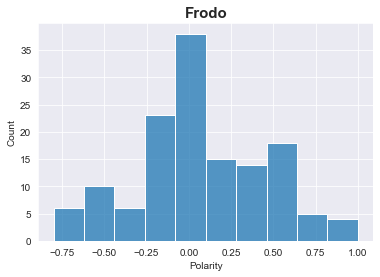

In [118]:
# distribution frodo
frodo_dist = sns.histplot(data=frodo_sa_df, x="Polarity")
frodo_dist.set_title("Frodo", fontsize=15, fontweight="bold")

In [119]:
#frodo_dist.figure.savefig("visualizations/barplots/frodo_pol_dist.jpg", dpi=300)

Text(0.5, 1.0, 'Gandalf')

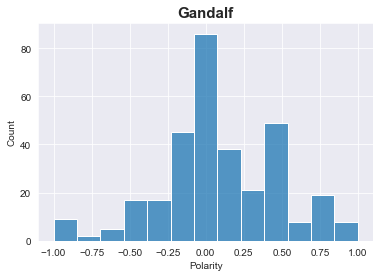

In [121]:
# distribution gandalf
gandalf_dist = sns.histplot(data=gandalf_sa_df, x="Polarity")
gandalf_dist.set_title("Gandalf", fontsize=15, fontweight="bold")

In [122]:
#gandalf_dist.figure.savefig("visualizations/barplots/gandalf_pol_dist.jpg", dpi=300)

Text(0.5, 1.0, 'Sam')

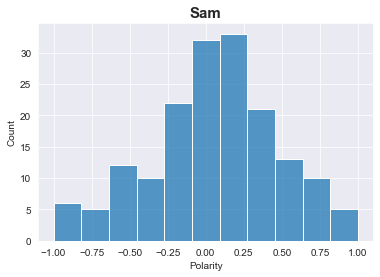

In [124]:
# distribution sam
sam_dist = sns.histplot(data=sam_sa_df, x="Polarity")
sam_dist.set_title("Sam", fontsize=15, fontweight="bold")

In [125]:
#sam_dist.figure.savefig("visualizations/barplots/sam_pol_dist.jpg", dpi=300)

Text(0.5, 1.0, 'Aragorn')

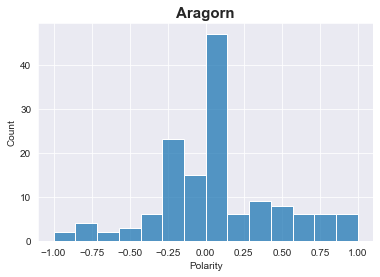

In [127]:
# distribution aragorn
aragorn_dist = sns.histplot(data=aragorn_sa_df, x="Polarity")
aragorn_dist.set_title("Aragorn", fontsize=15, fontweight="bold")

In [128]:
#aragorn_dist.figure.savefig("visualizations/barplots/aragorn_pol_dist.jpg", dpi=300)

Text(0.5, 1.0, 'Gollum/Smeagol')

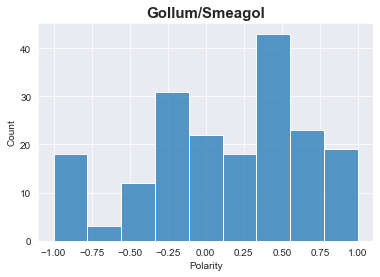

In [129]:
# distribution gollum/smeagol
gollum_smeagol_dist = sns.histplot(data=gollum_smeagol_sa_df, x="Polarity")
gollum_smeagol_dist.set_title("Gollum/Smeagol", fontsize=15, fontweight="bold")

In [130]:
#gollum_smeagol_dist.figure.savefig("visualizations/barplots/gollum_smeagol_pol_dist.jpg", dpi=300)

## Wordclouds  <a class="anchor" id="wordclouds"></a>

### Frodo

In [97]:
sa_frodo_words = getPolarityWordsForCloud(frodo_sa_df)
sa_frodo_words

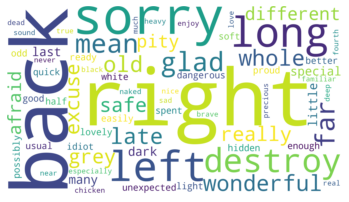

In [98]:
frodo = make_wordcloud(sa_frodo_words)

In [92]:
# frodo.to_file("visualizations/wordclouds/sa_wordcloud_frodo.jpg")

### Gandalf

In [100]:
sa_gandalf_words = getPolarityWordsForCloud(gandalf_sa_df)
sa_gandalf_words

'down down far never late early precisely old special good barely little really very old good old not aged mean very terribly clever many magic lightly behind hard angry precious long enough cheap long sure next dark precious precious left secret safe second high precious great first clear red secret only secret safe cool few not utter common dark quiet old evil only second above dark other first long endless safe good great terrible quickly wise powerful behind not safe outside only really amazing down little late better careful many safe dark back wants long very enough quickly dangerous wise lucky few more sorry not lightly only only hardly left no more great black evil right long left open no other old careful evil outside own many good evil greater own only simple open open little useless long dark older deep quietly other unnoticed worth greater following loose sad mad pity pity many live very wise good ill pity many live such other evil down little more light great dead second l

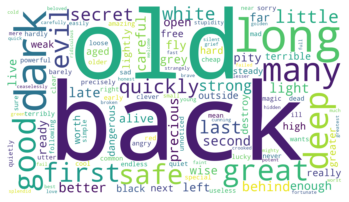

In [101]:
gandalf = make_wordcloud(sa_gandalf_words)

In [102]:
#gandalf.to_file("visualizations/wordclouds/sa_wordcloud_gandalf.jpg")

### Sam

In [103]:
sa_sam_words = getPolarityWordsForCloud(sam_sa_df)
sa_sam_words

'good good honest cutting important good dark more sad dirty great back able not mean short quiet down whole half back cold far alive blue green long nice not mean not mean not natural chicken very special best down really real free lovely more not usually foreign not bad strangely familiar nasty quiet no more down down back back old much hate quiet sound good dead dead right black dead right old past down stinker far left wants barely sound sick only hardly few good lovely big golden nice ready innocent destroy such right mad wrong great really full happy back much bad only new small back only good worth very not mean no hard very decent very decent favorite really most fun serious brave much late right much left careful enough little own miserable little near decent back good proper not right back no more no more stinker back right right fine own sorry dark filthy sorry not mean far angry right exhausted not mean back dead not dead old first only best down last filthy straight not su

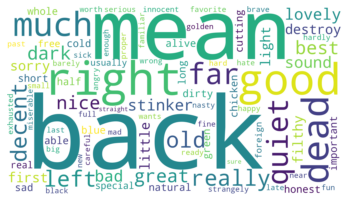

In [104]:
sam = make_wordcloud(sa_sam_words)

In [105]:
#sam.to_file("visualizations/wordclouds/sa_wordcloud_sam.jpg")

### Aragorn

In [106]:
sa_aragorn_words = getPolarityWordsForCloud(aragorn_sa_df)
sa_aragorn_words

'far much little more entirely rare not nearly enough little great dead wild love great slow very dangerous hard back welcome grey same same no other down enough down back brave back dead wild steady steady courteous very dangerous very dangerous white long clever long old cross very bravely white fail white true other left behind light less strange evil plain captive small only other strange quick trouble ill enough good loyal open only best deep past fast quiet fast quiet quiet quiet quiet free enough good good only small few left long hidden never more open grief more left ten strong least single destroy destroy destroy down last above last more good most welcome down back back long long no other no other many most enough broken love joy first down no further past safe empty full black fixed blind long long no more black back back same fails down good great '

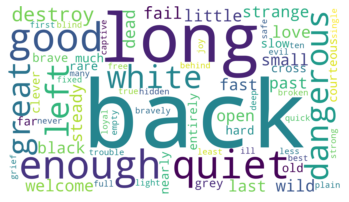

In [107]:
aragorn = make_wordcloud(sa_aragorn_words)

In [108]:
#aragorn.to_file("visualizations/wordclouds/sa_wordcloud_aragorn.jpg")

### Gollum/Smeagol

In [109]:
sa_gollum_smeagol_words = getPolarityWordsForCloud(gollum_smeagol_sa_df)
sa_gollum_smeagol_words

'precious own love own precious precious filthy little precious wants nasty twisted nice nice wants precious precious precious precious back precious great very lucky nice safe quickly round quickly soft quick precious tries cruel precious dead great long dead careful down dead light little own bright beautiful precious cold cold far failed dead quick dead precious black very black good wants precious precious back more secret dark good wants precious little false precious false hate hate back back back precious free young nice stupid ruins precious nice raw nasty dark long ready last nice cool sweet only sweet cruel false filthy little precious only no hard nice poor poor false filthy little precious precious dead dead long love wants precious precious cool nice only sweet sound own precious silly very very no safe quiet precious love nasty wants dead precious back love first filthy very nice precious not very nice love empty precious dead fly nasty decent dead very nasty full quick q

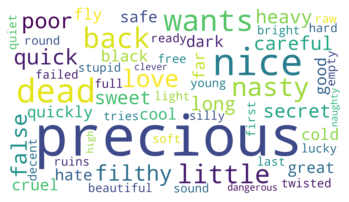

In [110]:
gollum = make_wordcloud(sa_gollum_smeagol_words)

In [111]:
#gollum.to_file("visualizations/wordclouds/sa_wordcloud_gollum_smeagol.jpg")

 ## Line Plots <a class="anchor" id="lineplots"></a>
 → [Lineplot Helper Function](#lineplot_function)

### Line Plot - All Characters

Text(0, 0.5, 'Polarity Index')

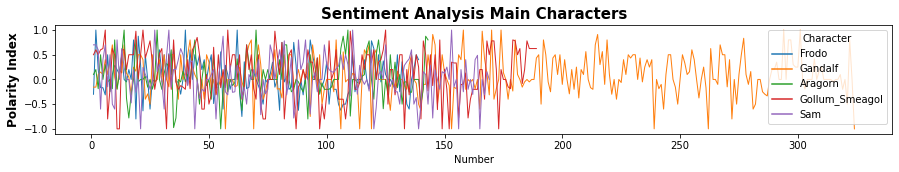

In [34]:
# Plot sentiment analysis for all characters
plt.figure(figsize=(15,2))
all_characters_sa_lineplot = sns.lineplot(x="Number", y="Polarity", linewidth=1,
             hue="Character",
             data=all_characters_sa_df)
all_characters_sa_lineplot.set_title("Sentiment Analysis Main Characters", fontsize=15, fontweight="bold")
# all_characters_sa_lineplot.set_xlabel("Verlauf", fontsize=15, fontweight="bold")
all_characters_sa_lineplot.set_ylabel("Polarity Index", fontsize=12, fontweight="bold")
#all_characters_sa_lineplot.figure.savefig("visualizations/lineplots/all_characters_sa_lineplot.jpg", dpi=300)

### Line Plots - Individual Characters

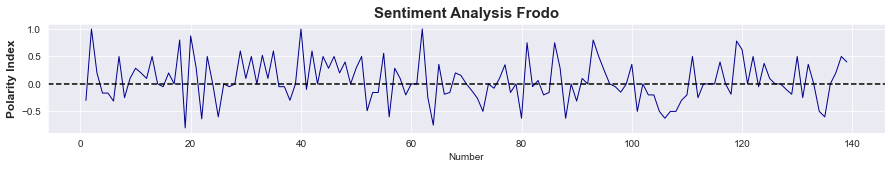

In [35]:
# Plot sentiment analysis Frodo
frodo_sa_lineplot = make_line_plot(frodo_sa_df, "Frodo")
# frodo_sa_lineplot.figure.savefig("visualizations/lineplots/frodo_sa_lineplot.jpg", dpi=300)

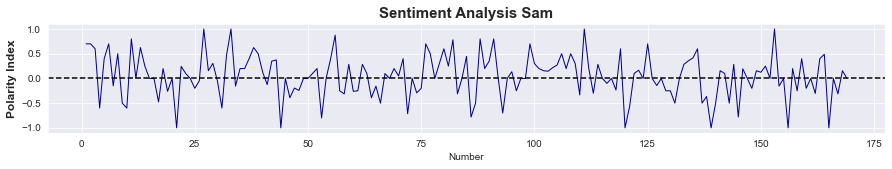

In [36]:
# Plot sentiment analysis Sam
sam_sa_lineplot = make_line_plot(sam_sa_df, "Sam")
# sam_sa_lineplot.figure.savefig("visualizations/lineplots/sam_sa_lineplot.jpg", dpi=300)

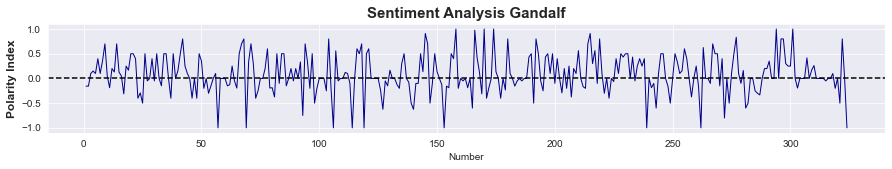

In [37]:
# Plot sentiment analysis Gandalf
gandalf_sa_lineplot = make_line_plot(gandalf_sa_df, "Gandalf")
# gandalf_sa_lineplot.figure.savefig("visualizations/lineplots/gandalf_sa_lineplot.jpg", dpi=300)

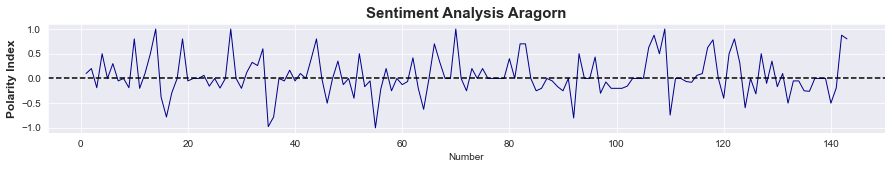

In [38]:
# Plot sentiment analysis Aragorn
aragorn_sa_lineplot = make_line_plot(aragorn_sa_df, "Aragorn")
# aragorn_sa_lineplot.figure.savefig("visualizations/lineplots/aragorn_sa_lineplot.jpg", dpi=300)

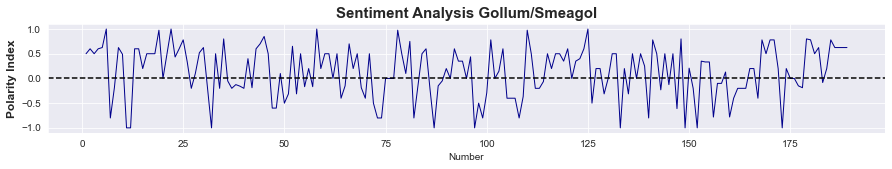

In [39]:
# Plot sentiment analysis Gollum/Smeagol
gollum_smeagol_sa_lineplot = make_line_plot(gollum_smeagol_sa_df, "Gollum/Smeagol")
# gollum_smeagol_sa_lineplot.figure.savefig("visualizations/lineplots/gollum_smeagol_sa_lineplot.jpg", dpi=300)

## Barcode Plots <a class="anchor" id="barcodeplots"></a> 
 → [Barcodeplot Helper Function](#barcodeplot_function)
 
 barcode plots inspired by: https://nbviewer.org/github/rickystream94/rickystream94.github.io/blob/master/social_graphs/Final_Project.ipynb

### Barcode: Frodo

Differenz Start-Ende: 0.01


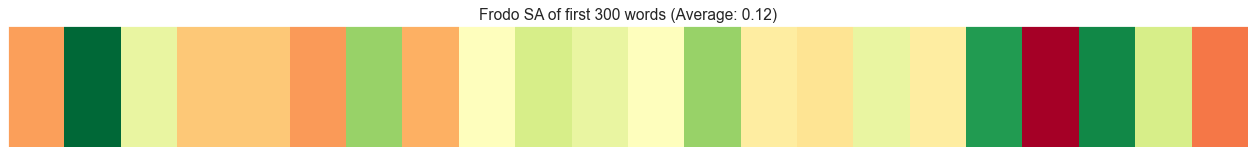

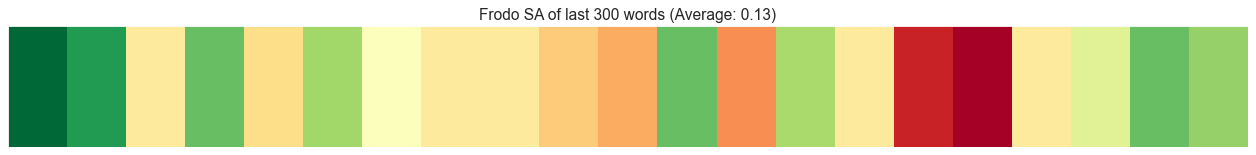

In [40]:
frodo_polarity_start = frodo_300_start_sa_df["Polarity"]
frodo_polarity_end = frodo_300_end_sa_df["Polarity"]

barcodeplot(frodo_polarity_start, frodo_polarity_end, "Frodo")

## Sam

Differenz Start-Ende: -0.2


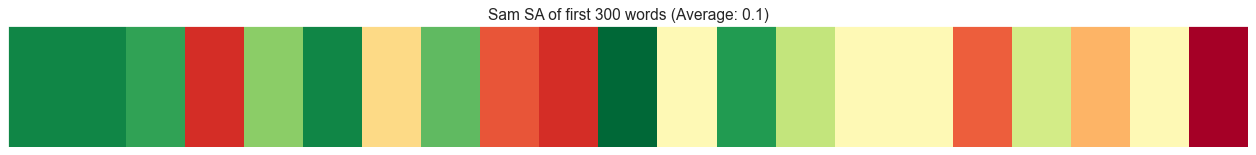

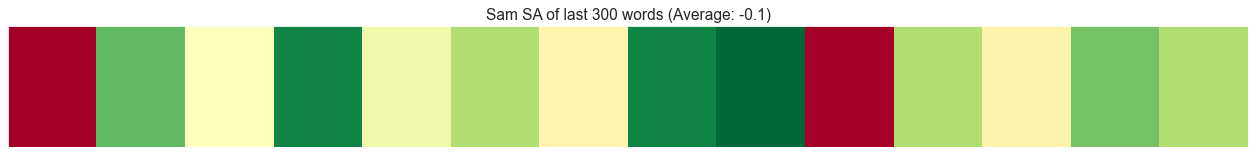

In [41]:
sam_polarity_start = sam_300_start_sa_df["Polarity"]
sam_polarity_end = sam_300_end_sa_df["Polarity"]

barcodeplot(sam_polarity_start, sam_polarity_end, "Sam")

## Aragorn

Differenz Start-Ende: -0.14


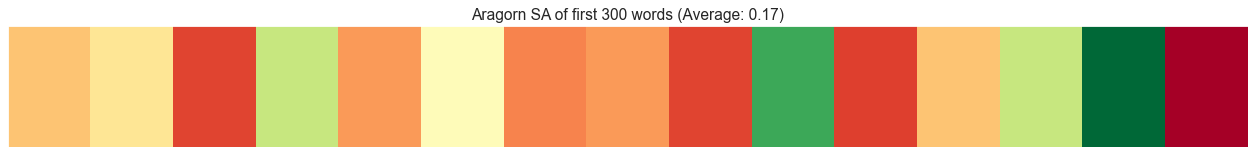

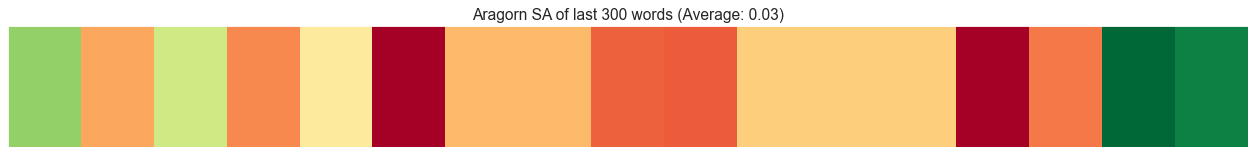

In [42]:
aragorn_polarity_start = aragorn_300_start_sa_df["Polarity"]
aragorn_polarity_end = aragorn_300_end_sa_df["Polarity"]

barcodeplot(aragorn_polarity_start, aragorn_polarity_end, "Aragorn")

## Gandalf

Differenz Start-Ende: -0.12


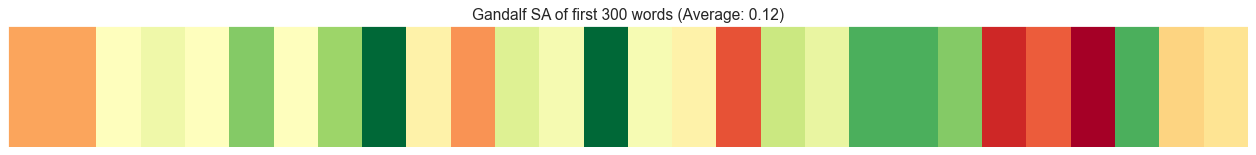

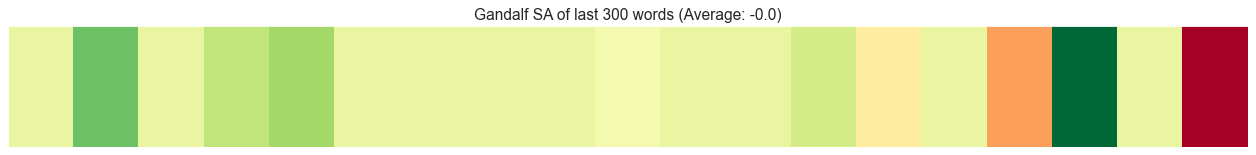

In [43]:
gandalf_polarity_start = gandalf_300_start_sa_df["Polarity"]
gandalf_polarity_end = gandalf_300_end_sa_df["Polarity"]

barcodeplot(gandalf_polarity_start, gandalf_polarity_end, "Gandalf")

## Gollum / Smeagol

Differenz Start-Ende: -0.15


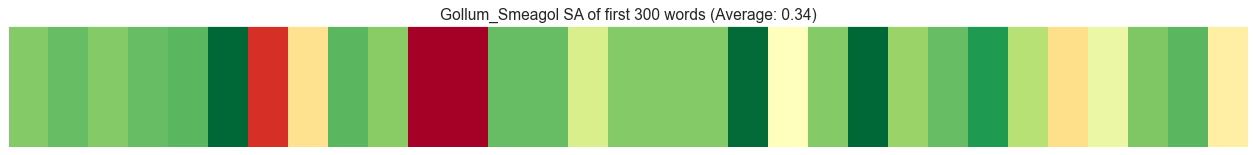

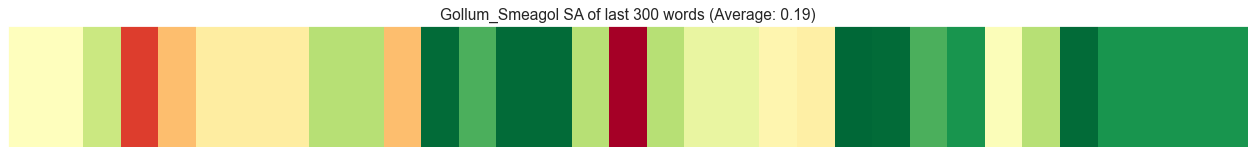

In [44]:
gollum_polarity_start = gollum_smeagol_300_start_sa_df["Polarity"]
gollum_polarity_end = gollum_smeagol_300_end_sa_df["Polarity"]

barcodeplot(gollum_polarity_start, gollum_polarity_end, "Gollum_Smeagol")

## Results

**Polarity Ranking -  Difference from Start to End**

1.) Sam:  -0.2 (0.1 → -0.1)

2.) Gollum/Smeagol: -0.15 (0.34 → 0.19)

3.) Aragorn:  -0.14 (0.17 → 0.03)

4.) Gandalf: -0.12 (0.12 → 0.0)

5.) Frodo: 0.01 (0.12 → 0.13)


## Compare spacytextblob to Other Sentiment Analysis Tools <a class="anchor" id="tool_comparison"></a>

Since the results with spacytexblob were not great, two further sentiment analysis tools are explored to compare their results: TextBlob's NaiveBayesAnalyzer and Stanford NLPCore.

The data to be compared are the first 300 words of Frodo's dialog text.

### spacytextblob

**Results:**
* 63 sentences in total, but only 17 have a polarity other than 0.0
* 300 words in total, but only 20 have a polarity other than 0.0: wonderful, whole, half, odd, mean, more, usual, old, right, very, unexpected, glad, long, really, proud, idiot, good, right and hidden.
* Problem: Those words are not very characteristic of what Frodo actually says.
* Problem: 20 words are too few to calculate a reliable average.

In [45]:
# define nlp doc to compare
doc_frodo_300_start = nlp(frodo_300_start)

In [46]:
# polarity frodo per sentence
getPolarityPerSentence(doc_frodo_300_start)

you're late. -0.3
it's wonderful to see you, gandalf! 1.0
you know bilbo. 0.0
he's got the whole piece in an uproar. 0.2
half the shire's been invited. -0.16666666666666666
and the rest of them are turning up anyway. 0.0
to tell you the truth, bilbo's been a bit odd lateiy. -0.16666666666666666
i mean, more than usual. -0.020833333333333332
he's taken to locking himself in his study. 0.0
he spends hours and hours poring over old maps when he thinks i'm not looking. 0.1
he's up to something. 0.0
all right, then. 0.2857142857142857
keep your secrets. 0.0
but i know you have something to do with it. 0.0
before you came along, we bagginses were very well thought of. 0.2
never had any adventures or did anything unexpected. 0.1
whatever you did, you've been officially labeled a disturber of the peace. 0.0
gandalf? 0.0
i'm glad you're back. 0.25
go on, sam. 0.0
ask rosie for a dance. 0.0
oh, no, you do not. 0.0
go on! 0.0
bilbo? 0.0
bilbo, have you been at the gaffer's home brew? bilbo. 0.0
b

In [47]:
# polarity frodo per sentence without zeros
getPolarityPerSentenceWithoutZero(doc_frodo_300_start)

you're late. -0.3
it's wonderful to see you, gandalf! 1.0
he's got the whole piece in an uproar. 0.2
half the shire's been invited. -0.16666666666666666
to tell you the truth, bilbo's been a bit odd lateiy. -0.16666666666666666
i mean, more than usual. -0.020833333333333332
he spends hours and hours poring over old maps when he thinks i'm not looking. 0.1
all right, then. 0.2857142857142857
before you came along, we bagginses were very well thought of. 0.2
never had any adventures or did anything unexpected. 0.1
i'm glad you're back. 0.25
he talked for so long about leaving i did not think he'd really do it. 0.07500000000000001
and proud of it. 0.8
rosie knows an idiot when she sees one. -0.8
good night, sam. 0.7
all right. 0.2857142857142857
we keep it hidden. -0.16666666666666666
Total: 17 sentences


In [48]:
# frodo sentences with polarity = 0.0
getSentencesWithZeroPolarity(doc_frodo_300_start)

you know bilbo. 0.0
and the rest of them are turning up anyway. 0.0
he's taken to locking himself in his study. 0.0
he's up to something. 0.0
keep your secrets. 0.0
but i know you have something to do with it. 0.0
whatever you did, you've been officially labeled a disturber of the peace. 0.0
gandalf? 0.0
go on, sam. 0.0
ask rosie for a dance. 0.0
oh, no, you do not. 0.0
go on! 0.0
bilbo? 0.0
bilbo, have you been at the gaffer's home brew? bilbo. 0.0
bilbo, watch out for the dragon! speech! 0.0
bilbo! 0.0
bilbo! 0.0
he's gone, has not he? 0.0
gandalf? 0.0
where are you going? 0.0
what things? 0.0
you've only just arrived. 0.0
i do not understand. 0.0
cheers, gaffer. 0.0
do not worry, sam. 0.0
what are you doing? nothing. 0.0
there's nothing. 0.0
wait. 0.0
there are markings. 0.0
it's some form of elvish. 0.0
i can nott read it. 0.0
mordor! 0.0
bilbo found it. 0.0
in gollum's cave. 0.0
but he was destroyed. 0.0
sauron was destroyed. 0.0
we put it away. 0.0
we never speak of it again. 0.0

In [49]:
# polarity frodo per word
getPolarityPerWord(doc_frodo_300_start)

you PRON 0.0
're AUX 0.0
late ADJ -0.3
. PUNCT 0.0
it PRON 0.0
's AUX 0.0
wonderful ADJ 1.0
to PART 0.0
see VERB 0.0
you PRON 0.0
, PUNCT 0.0
gandalf NOUN 0.0
! PUNCT 0.0
you PRON 0.0
know VERB 0.0
bilbo PROPN 0.0
. PUNCT 0.0
he PRON 0.0
's AUX 0.0
got VERB 0.0
the DET 0.0
whole ADJ 0.2
piece NOUN 0.0
in ADP 0.0
an DET 0.0
uproar NOUN 0.0
. PUNCT 0.0
half DET -0.16666666666666666
the DET 0.0
shire NOUN 0.0
's AUX 0.0
been AUX 0.0
invited VERB 0.0
. PUNCT 0.0
and CCONJ 0.0
the DET 0.0
rest NOUN 0.0
of ADP 0.0
them PRON 0.0
are AUX 0.0
turning VERB 0.0
up ADP 0.0
anyway ADV 0.0
. PUNCT 0.0
to PART 0.0
tell VERB 0.0
you PRON 0.0
the DET 0.0
truth NOUN 0.0
, PUNCT 0.0
bilbo PROPN 0.0
's PART 0.0
been AUX 0.0
a DET 0.0
bit NOUN 0.0
odd ADJ -0.16666666666666666
lateiy NOUN 0.0
. PUNCT 0.0
i PRON 0.0
mean VERB -0.3125
, PUNCT 0.0
more ADJ 0.5
than ADP 0.0
usual ADJ -0.25
. PUNCT 0.0
he PRON 0.0
's AUX 0.0
taken VERB 0.0
to ADP 0.0
locking VERB 0.0
himself PRON 0.0
in ADP 0.0
his PRON 0.0
stud

In [50]:
# get polarity frodo without zeros
getPolarityPerWordWithoutZeros(doc_frodo_300_start)

late ADJ -0.3
wonderful ADJ 1.0
whole ADJ 0.2
half DET -0.16666666666666666
odd ADJ -0.16666666666666666
mean VERB -0.3125
more ADJ 0.5
usual ADJ -0.25
old ADJ 0.1
right ADV 0.2857142857142857
very ADV 0.2
unexpected ADJ 0.1
glad ADJ 0.5
long ADV -0.05
really ADV 0.2
proud ADJ 0.8
idiot NOUN -0.8
good ADJ 0.7
right ADV 0.2857142857142857
hidden ADJ -0.16666666666666666
Total: 20 words


In [51]:
# get zero word polarities frodo
getZeroPolarityPerWord(doc_frodo_300_start)

you PRON 0.0
're AUX 0.0
. PUNCT 0.0
it PRON 0.0
's AUX 0.0
to PART 0.0
see VERB 0.0
you PRON 0.0
, PUNCT 0.0
gandalf NOUN 0.0
! PUNCT 0.0
you PRON 0.0
know VERB 0.0
bilbo PROPN 0.0
. PUNCT 0.0
he PRON 0.0
's AUX 0.0
got VERB 0.0
the DET 0.0
piece NOUN 0.0
in ADP 0.0
an DET 0.0
uproar NOUN 0.0
. PUNCT 0.0
the DET 0.0
shire NOUN 0.0
's AUX 0.0
been AUX 0.0
invited VERB 0.0
. PUNCT 0.0
and CCONJ 0.0
the DET 0.0
rest NOUN 0.0
of ADP 0.0
them PRON 0.0
are AUX 0.0
turning VERB 0.0
up ADP 0.0
anyway ADV 0.0
. PUNCT 0.0
to PART 0.0
tell VERB 0.0
you PRON 0.0
the DET 0.0
truth NOUN 0.0
, PUNCT 0.0
bilbo PROPN 0.0
's PART 0.0
been AUX 0.0
a DET 0.0
bit NOUN 0.0
lateiy NOUN 0.0
. PUNCT 0.0
i PRON 0.0
, PUNCT 0.0
than ADP 0.0
. PUNCT 0.0
he PRON 0.0
's AUX 0.0
taken VERB 0.0
to ADP 0.0
locking VERB 0.0
himself PRON 0.0
in ADP 0.0
his PRON 0.0
study NOUN 0.0
. PUNCT 0.0
he PRON 0.0
spends VERB 0.0
hours NOUN 0.0
and CCONJ 0.0
hours NOUN 0.0
poring NOUN 0.0
over ADP 0.0
maps NOUN 0.0
when SCONJ 0.0

### Test: Sentiment Analysis with TextBlob's NaiveBayesAnalyzer

**NaiveBayesAnalyzer**
* machine learning based method
* "an NLTK model trained on a movie reviews corpus" (https://stackabuse.com/sentiment-analysis-in-python-with-textblob/)
* returns for each document/sentence/word etc. a pos-value, a neg-value and an overall classification.
* advantage: each word can receive a polarity, there are no polarities of zero
* disadvantages:
    * very slow (ca. 2 seconds per computation)
    * tendency towards positive classification: if pos-value and neg-value are the same, the classification is positive -> neutral missing

In [52]:
# overall score
blob = TextBlob(frodo_300_start, analyzer=NaiveBayesAnalyzer())
blob.sentiment

Sentiment(classification='pos', p_pos=0.9999999806973635, p_neg=1.9302620470121112e-08)

In [53]:
# results in file: frodo_300_SA_per_sentence_bayes.txt
#getPolarityPerSentenceBayes(frodo_300_start)

In [54]:
# results in file: frodo_300_SA_per_word_bayes.txt
# getPolarityPerWordBayes(frodo_300_start_list)

### Stanford NLPCore

We used the live demo to get a first impression of the results. We pasted the first 300 words of Frodo's dialog into the live demo box.

Live Demo: http://nlp.stanford.edu:8080/sentiment/rntnDemo.html

For a deeper analysis the Python integration of NLPCore would be an option. This could be considered in future research.

NLPCore in Python: https://towardsdatascience.com/natural-language-processing-using-stanfords-corenlp-d9e64c1e1024

**Stanford CoreNLP**
* Categorizes words as: very negative, negative, neutral, positive, very positive
* trained on movie review corpus
* works with a [sentiment treebank](https://nlp.stanford.edu/sentiment/treebank.html) as corpus, does not only analyze words but takes sentence context into account as well
* based on recursive neural network


Source: https://nlp.stanford.edu/sentiment/index.html

**Results:**
* 66 sentences identified, 34 with neutral polarity, 32 with polarity other than neutral → more sentences with polarities identified than TextBlob
* many sentences have only few words that actually have a polarity (similarity to other tools)
* only 2 sentences with strong polarity (strongly positive)
* advantages of live demo:
    * visual output → easier to get an overview
* disadvantages of live demo: 
    * download feature not available
    * polarity calculations are not displayed, only colors and +/-

**Evaluation:**
The Stanford model seems to be the most promising sentiment analysis method and should be considered for future work on the LOTR-Corups rather than TextBlob.